# ATC class prediction from drug structure using CNNs
MI-MVI  
Jiří Reiniš  
reinijir@fit.cvut.cz

## Imports

In [0]:
from google.colab import drive

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.image import imread

from sklearn.model_selection import train_test_split

from keras import backend
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import SGD, RMSprop, Adam
from keras.applications.vgg16 import VGG16
from keras import losses


## Connect notebook to Google Drive

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Load data

In [0]:
data_path = '/content/gdrive/My Drive/MVI_semestralka/'
images_path = '/content/gdrive/My Drive/MVI_semestralka/PNG_small/'
figure_path = '/content/gdrive/My Drive/MVI_semestralka/fig/'
ids_labels_path = '/content/gdrive/My Drive/MVI_semestralka/dataset_master_multiclass_numpy_array_encoded_pickled'

In [0]:
df = pd.read_pickle(ids_labels_path)
df.sample(6, random_state = 42)

KEGG_ID                                             labels
298   D07586  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3079  D01137  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
1361  D02190  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2712  D07367  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2417  D07298  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3358  D07517  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

### Plot some structures

In [0]:
fig = plt.figure(figsize=(4, 4), dpi= 80, facecolor='w', edgecolor='k')

for i in range(4):
	plt.subplot(220 + 1 + i)
	filename = images_path + df.iloc[i,0] + '.png'
	picture = imread(filename)
	plt.imshow(picture)
plt.show()

### Load images

In [0]:
def load_dataset(df, images_path):
	photos, targets = list(), list()
	
	for i in range(df.shape[0]):
		photo = image.load_img(images_path + df.iloc[i,0] + ".png", target_size=(128,128))
		photo = image.img_to_array(photo, dtype='uint8')
		photos.append(photo)
		targets.append(df.iloc[i,1])
	
	X = np.asarray(photos, dtype='uint8')
	y = np.asarray(targets, dtype='uint8')
	return X, y

In [0]:
X, y = load_dataset(df, images_path)

In [0]:
np.savez_compressed(data_path+'ATC_data_small.npz', X, y)

### Reload data if needed

In [161]:
data = np.load(data_path+'ATC_data_small.npz')
X, y = data['arr_0'], data['arr_1']
print('Loaded: ', X.shape, y.shape)

Loaded:  (3797, 128, 128, 3) (3797, 14)


### Train-validation split

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
X_train.shape

(2543, 128, 128, 3)

## Define metrics: F-beta score, 5 metrics from article
Implementation of F-beta for Keras taken from this tutorial:  
https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/

In [0]:
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score
  

In [0]:
def get_metrics(Y_true, Y_pred):
    classes = [1,10,11,12,13,14,2,3,4,5,6,7,8,9]
    N = len(Y_true)
    M = len(classes)
    
    aiming, coverage, accuracy = 0,0,0
    abstrue, absfalse = 0,0
    
    for i in range(N):
        # get true and predicted class labels for record
        real = set([a*b for a,b in zip([int(x) for x in Y_true[i]], classes) if a*b])
        pred = set([a*b for a,b in zip([int(x) for x in Y_pred[i]], classes) if a*b])
        
        real_pred_intersect_n = len(real.intersection(pred))
        real_pred_union_n = len(real.union(pred))

        if len(pred):
            aiming  += real_pred_intersect_n/len(pred)
        coverage += real_pred_intersect_n/len(real)
        if real_pred_union_n:
            accuracy += real_pred_intersect_n/real_pred_union_n
        if real == pred:
            abstrue += 1
            
        absfalse += (real_pred_union_n - real_pred_intersect_n)/M
    aiming, coverage, accuracy, abstrue, absfalse = aiming/N, coverage/N, accuracy/N, abstrue/N, absfalse/N
    print("aiming = {}\ncoverage = {}\naccuracy = {}\nabstrue = {}\nabsfalse={}".format(
        aiming, coverage, accuracy, abstrue, absfalse))

### Loss function visualization

In [0]:
def summarize_diagnostics(history, filename = None):
	plt.figure(figsize=(6, 7))
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
	plt.subplot(212)
	plt.title('Fbeta')
	plt.plot(history.history['fbeta'], color='blue', label='train')
	plt.plot(history.history['val_fbeta'], color='orange', label='val')
	plt.legend()

	if filename:
		plt.savefig(filename + ".svg", format="svg")

## Create and train a baseline model

In [0]:
# define cnn model
def baseline_model(lr = 0.01, optimizer = SGD(lr=0.01, momentum=0.9), in_shape=(128, 128, 3), out_shape=14):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(out_shape, activation='sigmoid'))
	# compile model
	opt = optimizer
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[fbeta])
	return model

In [0]:
# create data generator
datagen = ImageDataGenerator(rescale=1./255.)
# prepare iterators
train_it = datagen.flow(X_train, Y_train, batch_size=128)
val_it = datagen.flow(X_val, Y_val, batch_size=128)

#### Train model (stochastic gradient descent optimizer)

In [155]:
# get model
model = baseline_model()
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                              validation_data=val_it, validation_steps=len(val_it), epochs=30, verbose=1)

Epoch 1/30
20/20 [==============================] - 6s 309ms/step - loss: 3.4161 - fbeta: 0.3233 - val_loss: 3.2355 - val_fbeta: 0.3397
Epoch 2/30
20/20 [==============================] - 2s 109ms/step - loss: 3.2113 - fbeta: 0.3436 - val_loss: 3.2150 - val_fbeta: 0.3429
Epoch 3/30
20/20 [==============================] - 2s 110ms/step - loss: 3.1908 - fbeta: 0.3499 - val_loss: 3.1904 - val_fbeta: 0.3477
Epoch 4/30
20/20 [==============================] - 2s 110ms/step - loss: 3.1704 - fbeta: 0.3540 - val_loss: 3.1688 - val_fbeta: 0.3622
Epoch 5/30
20/20 [==============================] - 2s 110ms/step - loss: 3.1502 - fbeta: 0.3614 - val_loss: 3.1686 - val_fbeta: 0.3689
Epoch 6/30
20/20 [==============================] - 2s 109ms/step - loss: 3.1412 - fbeta: 0.3628 - val_loss: 3.1615 - val_fbeta: 0.3674
Epoch 7/30
20/20 [==============================] - 2s 110ms/step - loss: 3.1241 - fbeta: 0.3651 - val_loss: 3.1329 - val_fbeta: 0.3689
Epoch 8/30
20/20 [==============================

### Evaluate model

Training set
aiming = 0.40909452652473066
coverage = 0.8436754489448157
accuracy = 0.3983878870725156
abstrue = 0.11482500983090838
absfalse=0.14839053985731282

Validation set
aiming = 0.2402483481430848
coverage = 0.49557416267942567
accuracy = 0.2276341105288474
abstrue = 0.06060606060606061
absfalse=0.1929824561403511

> loss=3.128, fbeta=0.385


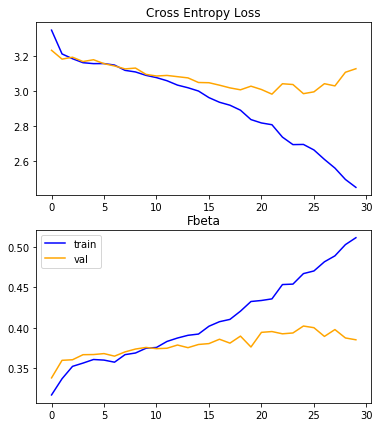

In [153]:
Y_pred = model.predict(X_val)
Y_train_pred = model.predict(X_train)

print("Training set")
get_metrics(Y_train, Y_train_pred)
print()
print("Validation set")
get_metrics(Y_val, Y_pred)
print()

loss, fbeta_metric = model.evaluate_generator(val_it, steps=len(val_it), verbose=0)
print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta_metric))
summarize_diagnostics(history, figure_path + "baseline_SGD")

### Let's give the model more epochs.

In [156]:
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                              validation_data=val_it, validation_steps=len(val_it), epochs=40, verbose=1)

Epoch 1/40
20/20 [==============================] - 2s 112ms/step - loss: 2.3864 - fbeta: 0.5224 - val_loss: 3.0087 - val_fbeta: 0.3936
Epoch 2/40
20/20 [==============================] - 2s 109ms/step - loss: 2.3274 - fbeta: 0.5263 - val_loss: 3.1485 - val_fbeta: 0.3834
Epoch 3/40
20/20 [==============================] - 2s 109ms/step - loss: 2.2767 - fbeta: 0.5389 - val_loss: 3.0916 - val_fbeta: 0.3524
Epoch 4/40
20/20 [==============================] - 2s 109ms/step - loss: 2.2450 - fbeta: 0.5393 - val_loss: 3.2068 - val_fbeta: 0.3598
Epoch 5/40
20/20 [==============================] - 2s 109ms/step - loss: 2.1781 - fbeta: 0.5376 - val_loss: 3.1759 - val_fbeta: 0.3579
Epoch 6/40
20/20 [==============================] - 2s 109ms/step - loss: 2.1082 - fbeta: 0.5489 - val_loss: 3.1746 - val_fbeta: 0.3378
Epoch 7/40
20/20 [==============================] - 2s 109ms/step - loss: 2.0275 - fbeta: 0.5636 - val_loss: 3.2849 - val_fbeta: 0.2947
Epoch 8/40
20/20 [==============================

In [157]:
Y_pred = model.predict(X_val)
Y_train_pred = model.predict(X_train)

print("Training set")
get_metrics(Y_train, Y_train_pred)
print()
print("Validation set")
get_metrics(Y_val, Y_pred)
print()

loss, fbeta_metric = model.evaluate_generator(val_it, steps=len(val_it), verbose=0)
print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta_metric))
summarize_diagnostics(history, figure_path + "baseline_SGD_overfitted")

Training set
aiming = 0.7630751081399918
coverage = 0.782192947961725
accuracy = 0.7554594311181017
abstrue = 0.723948092803775
absfalse=0.024942418965226528

Validation set
aiming = 0.14776714513556624
coverage = 0.1481924508240298
accuracy = 0.13075301891091373
abstrue = 0.10287081339712918
absfalse=0.08435862383230706

> loss=4.466, fbeta=0.140


### Train the same model but with Adam optimizer

In [145]:
# get model
model = baseline_model(optimizer=Adam())
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                              validation_data=val_it, validation_steps=len(val_it), epochs=30, verbose=1)

Epoch 1/30
20/20 [==============================] - 6s 299ms/step - loss: 3.7596 - fbeta: 0.3157 - val_loss: 3.2413 - val_fbeta: 0.3307
Epoch 2/30
20/20 [==============================] - 2s 110ms/step - loss: 3.2348 - fbeta: 0.3395 - val_loss: 3.2257 - val_fbeta: 0.3649
Epoch 3/30
20/20 [==============================] - 2s 110ms/step - loss: 3.2047 - fbeta: 0.3492 - val_loss: 3.2230 - val_fbeta: 0.3632
Epoch 4/30
20/20 [==============================] - 2s 110ms/step - loss: 3.1920 - fbeta: 0.3565 - val_loss: 3.2014 - val_fbeta: 0.3649
Epoch 5/30
20/20 [==============================] - 2s 110ms/step - loss: 3.1801 - fbeta: 0.3576 - val_loss: 3.1788 - val_fbeta: 0.3641
Epoch 6/30
20/20 [==============================] - 2s 111ms/step - loss: 3.1530 - fbeta: 0.3606 - val_loss: 3.1249 - val_fbeta: 0.3700
Epoch 7/30
20/20 [==============================] - 2s 110ms/step - loss: 3.1292 - fbeta: 0.3641 - val_loss: 3.1045 - val_fbeta: 0.3711
Epoch 8/30
20/20 [==============================

Training set
aiming = 0.673874126921708
coverage = 0.7138222571765632
accuracy = 0.6557215886747931
abstrue = 0.5835627211954385
absfalse=0.037834953092522446

Validation set
aiming = 0.1647129186602871
coverage = 0.17515948963317385
accuracy = 0.14912280701754382
abstrue = 0.11562998405103668
absfalse=0.08646616541353287

> loss=3.889, fbeta=0.166


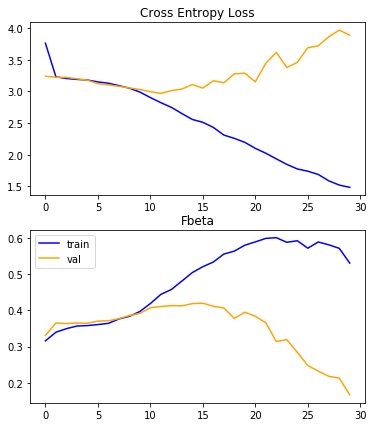

In [146]:
Y_pred = model.predict(X_val)
Y_train_pred = model.predict(X_train)

print("Training set")
get_metrics(Y_train, Y_train_pred)
print()
print("Validation set")
get_metrics(Y_val, Y_pred)
print()

loss, fbeta_metric = model.evaluate_generator(val_it, steps=len(val_it), verbose=0)
print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta_metric))
summarize_diagnostics(history, figure_path + "baseline_Adam")

### Try a different model: try transfer learning using a pretrained VGG16 

In [ ]:
def model_VGG16(in_shape=(128, 128, 3), out_shape=14):
	# load model
	model = VGG16(include_top=False, input_shape=in_shape)
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(out_shape, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.01)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[fbeta])
	return model

In [148]:
model = model_VGG16()
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                              validation_data=val_it, validation_steps=len(val_it), epochs=30, verbose=1)

Epoch 1/30
20/20 [==============================] - 6s 311ms/step - loss: 3.1712 - fbeta: 0.3370 - val_loss: 3.1330 - val_fbeta: 0.3639
Epoch 2/30
20/20 [==============================] - 3s 141ms/step - loss: 3.1316 - fbeta: 0.3583 - val_loss: 3.1245 - val_fbeta: 0.3565
Epoch 3/30
20/20 [==============================] - 3s 140ms/step - loss: 3.1150 - fbeta: 0.3585 - val_loss: 3.1160 - val_fbeta: 0.3699
Epoch 4/30
20/20 [==============================] - 3s 141ms/step - loss: 3.0968 - fbeta: 0.3554 - val_loss: 3.1212 - val_fbeta: 0.3271
Epoch 5/30
20/20 [==============================] - 3s 141ms/step - loss: 3.0879 - fbeta: 0.3532 - val_loss: 3.0688 - val_fbeta: 0.3529
Epoch 6/30
20/20 [==============================] - 3s 141ms/step - loss: 3.0654 - fbeta: 0.3346 - val_loss: 3.0613 - val_fbeta: 0.3572
Epoch 7/30
20/20 [==============================] - 3s 141ms/step - loss: 3.0486 - fbeta: 0.2938 - val_loss: 3.0531 - val_fbeta: 0.2881
Epoch 8/30
20/20 [==============================

Training set
aiming = 0.14267925022938785
coverage = 0.14036570979158475
accuracy = 0.12231148062842911
abstrue = 0.09280377506881636
absfalse=0.13386888377057726

Validation set
aiming = 0.13849016480595427
coverage = 0.13127325890483785
accuracy = 0.11594136857294753
abstrue = 0.0861244019138756
absfalse=0.133059922533606

> loss=2.842, fbeta=0.125


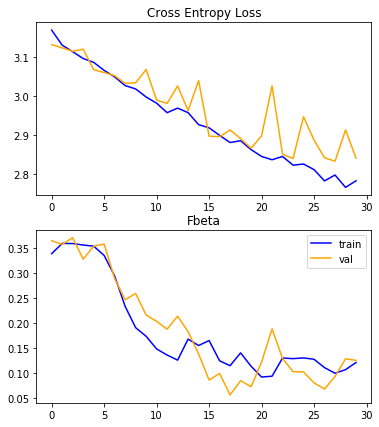

In [149]:
Y_pred = model.predict(X_val)
Y_train_pred = model.predict(X_train)

print("Training set")
get_metrics(Y_train, Y_train_pred)
print()
print("Validation set")
get_metrics(Y_val, Y_pred)
print()

loss, fbeta_metric = model.evaluate_generator(val_it, steps=len(val_it), verbose=0)
print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta_metric))
summarize_diagnostics(history, figure_path + "VGG16")

**Something is strange here. Maybe it is caused by class imbalance in the training set.**  
  
Let's look at the class proportions in the training set.

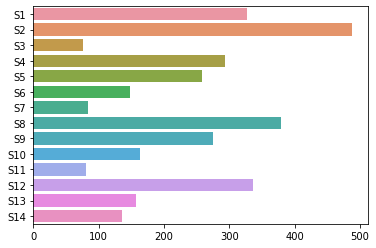

In [163]:
class_counts = [x for x in pd.DataFrame(Y_train).sum()]
classes = ['S'+str(i) for i in range(1,15)]

sns.barplot(class_counts, classes)
plt.savefig(figure_path + "train_set_imbalance.svg", format="svg")

Now, let's take a look at the predictions for the validation set.

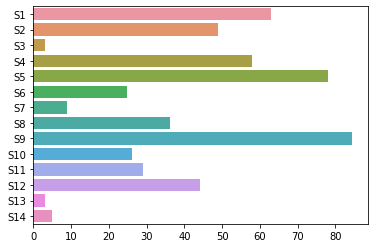

In [165]:
sns.barplot(pd.DataFrame(Y_pred).sum(), classes)
plt.savefig(figure_path + "prediction_imbalance.svg", format="svg")

Maybe we should do some class balancing...

### Load balanced training set and validation set

In [0]:
data_train = pd.read_pickle("/content/gdrive/My Drive/MVI_semestralka/data_train_balanced")
data_val = pd.read_pickle("/content/gdrive/My Drive/MVI_semestralka/data_val")

X_train, Y_train = load_dataset(data_train, images_path)
X_val, Y_val = load_dataset(data_val, images_path)

np.savez_compressed(data_path+'ATC_data_small_balanced_train.npz', X_train, Y_train)
np.savez_compressed(data_path+'ATC_data_small_balanced_validation.npz', X_val, Y_val)

### Reload if needed

In [0]:
data_train = np.load(data_path+'ATC_data_small_balanced_train.npz')
data_val = np.load(data_path+'ATC_data_small_balanced_validation.npz')

X_train, Y_train = data_train['arr_0'], data_train['arr_1']
X_val, Y_val = data_val['arr_0'], data_val['arr_1']

In [177]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((5814, 128, 128, 3), (5814, 14), (1254, 128, 128, 3), (1254, 14))

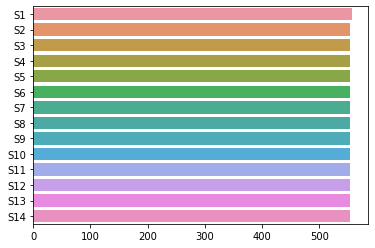

In [168]:
class_counts_balanced = [x for x in pd.DataFrame(Y_train).sum()]
sns.barplot(class_counts_balanced, classes)
plt.savefig(figure_path + "train_set_balanced.svg", format="svg")

In [0]:
# create data generator
datagen = ImageDataGenerator(rescale=1./255.)
# prepare iterators
train_it = datagen.flow(X_train, Y_train, batch_size=128)
val_it = datagen.flow(X_val, Y_val, batch_size=128)

### Try baseline model (SGD) on balanced data

In [178]:
# get model
model = baseline_model()

# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                              validation_data=val_it, validation_steps=len(val_it), epochs=30, verbose=1)

Epoch 1/30
46/46 [==============================] - 9s 199ms/step - loss: 3.5935 - fbeta: 0.3204 - val_loss: 3.3276 - val_fbeta: 0.3148
Epoch 2/30
46/46 [==============================] - 5s 101ms/step - loss: 3.5279 - fbeta: 0.3233 - val_loss: 3.3286 - val_fbeta: 0.3148
Epoch 3/30
46/46 [==============================] - 5s 101ms/step - loss: 3.5209 - fbeta: 0.3232 - val_loss: 3.3276 - val_fbeta: 0.3148
Epoch 4/30
46/46 [==============================] - 5s 101ms/step - loss: 3.5138 - fbeta: 0.3228 - val_loss: 3.3275 - val_fbeta: 0.3148
Epoch 5/30
46/46 [==============================] - 5s 101ms/step - loss: 3.5149 - fbeta: 0.3228 - val_loss: 3.3274 - val_fbeta: 0.3148
Epoch 6/30
46/46 [==============================] - 5s 101ms/step - loss: 3.5149 - fbeta: 0.3229 - val_loss: 3.3273 - val_fbeta: 0.3148
Epoch 7/30
46/46 [==============================] - 5s 100ms/step - loss: 3.5137 - fbeta: 0.3228 - val_loss: 3.3273 - val_fbeta: 0.3148
Epoch 8/30
46/46 [==============================

Training set
aiming = 0.18755016626533694
coverage = 0.24545636968237597
accuracy = 0.16322321326191377
abstrue = 0.07619539043687651
absfalse=0.14903680770553132

Validation set
aiming = 0.18253588516746425
coverage = 0.2354332801701223
accuracy = 0.15989215462899686
abstrue = 0.08054226475279107
absfalse=0.14821143768512207

> loss=2.938, fbeta=0.000


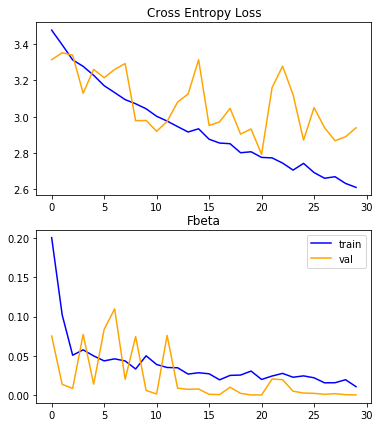

In [175]:
Y_pred = model.predict(X_val)
Y_train_pred = model.predict(X_train)

print("Training set")
get_metrics(Y_train, Y_train_pred)
print()
print("Validation set")
get_metrics(Y_val, Y_pred)
print()

loss, fbeta_metric = model.evaluate_generator(val_it, steps=len(val_it), verbose=0)
print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta_metric))
summarize_diagnostics(history, figure_path + "balanced_baseline_SGD")

### Baseline Adam on balanced data

In [171]:
# get model
model = baseline_model(optimizer=Adam())
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                              validation_data=val_it, validation_steps=len(val_it), epochs=30, verbose=1)

Epoch 1/30
46/46 [==============================] - 9s 194ms/step - loss: 3.7022 - fbeta: 0.3173 - val_loss: 3.3279 - val_fbeta: 0.3148
Epoch 2/30
46/46 [==============================] - 5s 101ms/step - loss: 3.5244 - fbeta: 0.3199 - val_loss: 3.3283 - val_fbeta: 0.2783
Epoch 3/30
46/46 [==============================] - 5s 101ms/step - loss: 3.5190 - fbeta: 0.3207 - val_loss: 3.3279 - val_fbeta: 0.3148
Epoch 4/30
46/46 [==============================] - 5s 102ms/step - loss: 3.5204 - fbeta: 0.3210 - val_loss: 3.3281 - val_fbeta: 0.3148
Epoch 5/30
46/46 [==============================] - 5s 102ms/step - loss: 3.5160 - fbeta: 0.3198 - val_loss: 3.3273 - val_fbeta: 0.3148
Epoch 6/30
46/46 [==============================] - 5s 102ms/step - loss: 3.5179 - fbeta: 0.3172 - val_loss: 3.3268 - val_fbeta: 0.3148
Epoch 7/30
46/46 [==============================] - 5s 101ms/step - loss: 3.5154 - fbeta: 0.3211 - val_loss: 3.3270 - val_fbeta: 0.3148
Epoch 8/30
46/46 [==============================

Training set
aiming = 0.0
coverage = 0.0
accuracy = 0.0
abstrue = 0.0
absfalse=0.09517666715808719

Validation set
aiming = 0.0
coverage = 0.0
accuracy = 0.0
abstrue = 0.0
absfalse=0.09005468215994417

> loss=3.327, fbeta=0.315


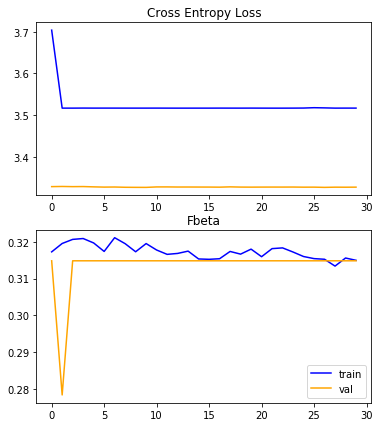

In [172]:
Y_pred = model.predict(X_val)
Y_train_pred = model.predict(X_train)

print("Training set")
get_metrics(Y_train, Y_train_pred)
print()
print("Validation set")
get_metrics(Y_val, Y_pred)
print()

loss, fbeta_metric = model.evaluate_generator(val_it, steps=len(val_it), verbose=0)
print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta_metric))
summarize_diagnostics(history, figure_path + "balanced_baseline_Adam")

### VGG16 on balanced data

In [173]:
# get model
model = model_VGG16()
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                              validation_data=val_it, validation_steps=len(val_it), epochs=30, verbose=1)

Epoch 1/30
46/46 [==============================] - 9s 201ms/step - loss: 3.4767 - fbeta: 0.1990 - val_loss: 3.3149 - val_fbeta: 0.0752
Epoch 2/30
46/46 [==============================] - 5s 115ms/step - loss: 3.3941 - fbeta: 0.1022 - val_loss: 3.3531 - val_fbeta: 0.0135
Epoch 3/30
46/46 [==============================] - 5s 115ms/step - loss: 3.3090 - fbeta: 0.0507 - val_loss: 3.3397 - val_fbeta: 0.0083
Epoch 4/30
46/46 [==============================] - 5s 115ms/step - loss: 3.2761 - fbeta: 0.0581 - val_loss: 3.1294 - val_fbeta: 0.0772
Epoch 5/30
46/46 [==============================] - 5s 115ms/step - loss: 3.2336 - fbeta: 0.0495 - val_loss: 3.2613 - val_fbeta: 0.0137
Epoch 6/30
46/46 [==============================] - 5s 115ms/step - loss: 3.1645 - fbeta: 0.0435 - val_loss: 3.2150 - val_fbeta: 0.0836
Epoch 7/30
46/46 [==============================] - 5s 115ms/step - loss: 3.1313 - fbeta: 0.0463 - val_loss: 3.2608 - val_fbeta: 0.1098
Epoch 8/30
46/46 [==============================

Training set
aiming = 0.18755016626533694
coverage = 0.24545636968237597
accuracy = 0.16322321326191377
abstrue = 0.07619539043687651
absfalse=0.14903680770553132

Validation set
aiming = 0.18253588516746425
coverage = 0.2354332801701223
accuracy = 0.15989215462899686
abstrue = 0.08054226475279107
absfalse=0.14821143768512207

> loss=2.938, fbeta=0.000


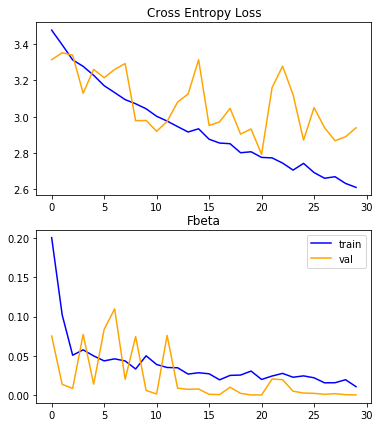

In [174]:
Y_pred = model.predict(X_val)
Y_train_pred = model.predict(X_train)

print("Training set")
get_metrics(Y_train, Y_train_pred)
print()
print("Validation set")
get_metrics(Y_val, Y_pred)
print()

loss, fbeta_metric = model.evaluate_generator(val_it, steps=len(val_it), verbose=0)
print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta_metric))
summarize_diagnostics(history, figure_path + "balanced_VGG16")

For some reason, dataset balancing did not help at all..